# Analyze wave height $H$ vs. vertical velocities $w$

In [37]:
# Imports
import os
import sys
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# Interactive plots
%matplotlib widget 
import cmocean
from roxsi_pyfuns import coordinate_transforms as rpct

In [4]:
# Paths and data
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
# RBR SoloD
data_solod = os.path.join(rootdir, 'RBRSoloD', 'Level1', 'netcdf')
fns_solod = sorted(glob.glob(os.path.join(data_solod, '*_pressure.nc')))
# RBR DuetDT
data_duetdt = os.path.join(rootdir, 'RBRDuetDT', 'Level1', 'netcdf')
fns_duetdt = sorted(glob.glob(os.path.join(data_duetdt, '*_pressure.nc')))
# Nortek Vector ADVs
data_vec = os.path.join(rootdir, 'Vectors', 'Level1', 'netcdf')
fns_vec = sorted(glob.glob(os.path.join(data_vec, '*Vec*.nc')))
# Nortek Signature 1000 ADCPs
data_sig = os.path.join(rootdir, 'Signatures', 'Level1', 'netcdf')

# Read bathymetry file (w/ mooring coordinates etc.)
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

## Vector vertical velocity vs. wave height
Use C3 mooring on top of the rock.

In [73]:
# Read vector Level1 netcdf file for mooring C3
ser = '17219' # Serial no. of C3 Vector
fn_vec = [f for f in fns_vec if ser in f]
print('Reading {} ...'.format(os.path.basename(fn_vec[0])))
dsv = xr.decode_cf(xr.open_dataset(fn_vec[0], decode_coords='all'))
t_end = pd.Timestamp('2022-07-25 00:00:00')
dsv = dsv.sel(time=slice(None, t_end))

# Convert despiked xyz velocities to ENU
print('Converting velocities ...')
enu = rpct.uvw2enu(vel=np.array([dsv.uxd.values, dsv.uyd.values, dsv.uzd.values]).T, 
                   heading=dsv.heading_ang.values, pitch=dsv.pitch_ang.values,
                   roll=dsv.roll_ang.values, magdec=12.86)

# Save variables to dataset
dsv['uE'] = (['time'], enu[0,:].copy())
dsv['uN'] = (['time'], enu[1,:].copy())
dsv['uU'] = (['time'], enu[2,:].copy())

# Reindex dataset to full time index
print('Reindexing to full time index ...')
time_ind_full = pd.date_range(dsv.time.isel(time=0).values, dsv.time.isel(time=-1).values,
                              freq='3125ms')
dsv = dsv.reindex(time=time_ind_full)


Reading Asilomar_SSA_L1_Vec_17219.nc ...


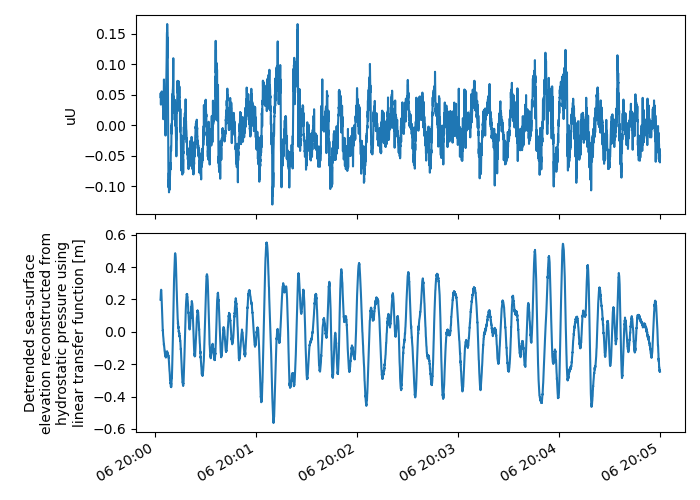

In [49]:
fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharex=True)
t0 = pd.Timestamp('2022-07-06 20:00:00')
t1 = pd.Timestamp('2022-07-06 20:05:00')
dsv.uU.sel(time=slice(t0, t1)).plot(ax=axes[0])
dsv.eta_lin.sel(time=slice(t0, t1)).plot(ax=axes[1])
axes[0].set_xlabel(None)
axes[1].set_xlabel(None)

plt.tight_layout()
plt.show()
# plt.clf()

/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mikapm/miniconda3/envs/roxsi/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis

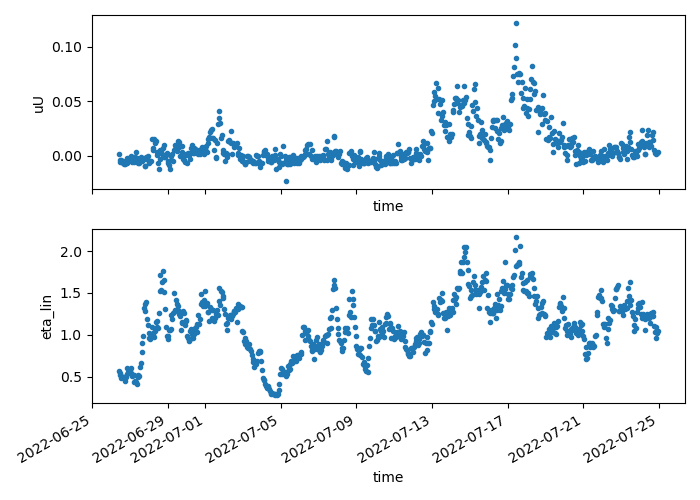

In [76]:
# Plot 20-minute mean vertical velocity vs Hs
def nan50_mean(da):
    return da.mean(dim='time').where(
        da.notnull().sum(dim='time') >= len(da.time)*0.5
    )
def nan50_std(da):
    return da.std(dim='time').where(
        da.notnull().sum(dim='time') >= len(da.time)*0.5
    )
fig, axes = plt.subplots(figsize=(7,5), nrows=2, sharex=True)
w_mean = dsv.uU.resample(time='20T').map(nan50_mean) 
w_mean.plot(ax=axes[0], linestyle='none', marker='.')
hs = dsv.eta_lin.resample(time='20T').map(nan50_std)*4
hs.plot(ax=axes[1], linestyle='none', marker='.')

plt.tight_layout()
plt.show()

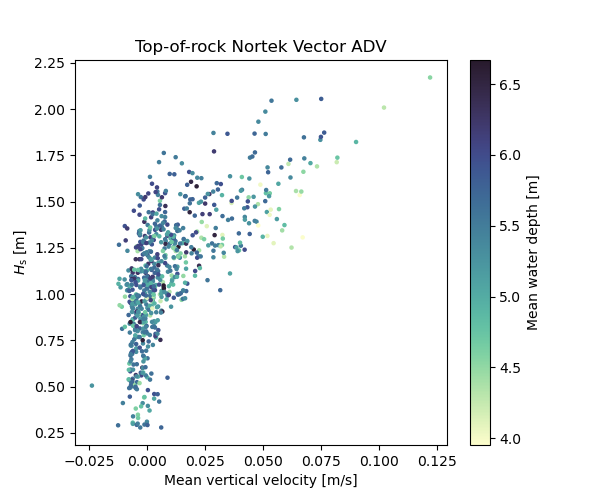

In [122]:
fig, ax = plt.subplots(figsize=(6,5))
vmin = 4
vmax = 7
h0 = dsv.eta_hyd.resample(time='20T').map(nan50_mean) 
cs = ax.scatter(w_mean.values, hs, c=h0, s=5, cmap=cmocean.cm.deep)
cbar=fig.colorbar(cs)
cbar.set_label('Mean water depth [m]')
ax.set_xlabel('Mean vertical velocity [m/s]')
ax.set_ylabel(r'$H_\mathrm{s}$ [m]')
ax.set_title('Top-of-rock Nortek Vector ADV')
outdir = '/home/mikapm/Documents'
fn = os.path.join(outdir, 'h_vs_w1.png')
plt.savefig(fn, bbox_inches='tight', dpi=300)
plt.show()

outdir = '/home/mikapm/Documents'
df = pd.DataFrame(data={'w_mean': w_mean.values, 'hs':hs.values, 'h0':h0.values})
df.to_csv(os.path.join(outdir, 'w_hs_h0.csv'))


In [99]:
# Wave-by-wave analysis
# Function to detect zero-crossings
def crossings_nonzero_pos2neg(data):
    """
    Returns indices for downwdard zero crossings in a time
    series, i.e. the zero crossings from positive to negative.

    Note that each index is for the 'last' value of the previous
    'wave', that is the last value of opposite sign before the
    zero crossing. Therefore must add one to the indices returned if
    don't want to include these values.
    
    Parameters:
        data: 1D array of sea-surface elevations.

    Borrowed from 
    https://stackoverflow.com/questions/3843017/efficiently-detect-sign-changes-in-python
    """
    pos = data > 0
    return (pos[:-1] & ~pos[1:]).nonzero()[0]

def crossings_nonzero_neg2pos(data):
    """
    Upward-zero-crossings function.
    """
    pos = data > 0
    npos = ~pos
    return ((npos[:-1] & pos[1:])).nonzero()[0]

# Function for zero-crossing wave-, crest-, and through heights 
def get_waveheights(ts, mean_signal=None, mean_signal2=None, method='down'):
    """
    Computes individual wave heights from signal ts.

    Returns the downward zero-crossing indices as well as an array 
    of individual wave heights (Hw) in the same units as the input 
    array. Also returns an array with crest heights (Hc) and trough 
    depths (Ht).

    If input mean_signal is given, compute mean values of this during 
    each wave. Should be the same size as ts.
    
    Parameters:
        ts - time series; np or xr array of measurements
        mean_signal - same shape as ts; signal for computing mean values of
                      during waves identified in ts.
        method - str; 'up' for upward-zero crossings, 'down' for downward z.c.

    Example usage:
        import os 
        from sw_pyfuns.data_extract import read_record
        datadir = '/home/mikapm/stereo-wave/data/ekofisk_test/lasar_records'
        fn = os.path.join(datadir, 'rec_ekofiskL_hz2_20180917_234000.hz2')
        rec = read_record(fn)
        from sw_pyfuns.analysis import get_waveheights_laser as gwl
        zc, Hw, Hc, Ht = gwl(rec)
    """
    # Make time series an np array just in case
    eta = np.array(ts)

    # Find indices of downward zero crossings in eta
    if method == 'down':
        # Downward-zero crossings
        zero_crossings = crossings_nonzero_pos2neg(eta)
    elif method == 'up':
        # Downward-zero crossings
        zero_crossings = crossings_nonzero_neg2pos(eta)
    # Add one to each index to get the correct intervals
    if zero_crossings[-1] < (len(eta)-1):
        zero_crossings += int(1)
    else:
        zero_crossings[:-1] += int(1)

    # Loop over the individual waves using zero-crossing indices
    Hc = [] # List for crest heights
    Ht = [] # List for trough heights
    Hw = [] # List for wave heights
    means = [] # List for wave-means of mean_signal
    means2 = [] # List for wave-means of mean_signal
    for i in range(len(zero_crossings)-1):
        start = zero_crossings[i]
        end = zero_crossings[i+1]
        # individual wave
        wave = eta[start:end]
        # crest of the wave
        h_crest = np.nanmax(wave)
        Hc.append(h_crest)
        # trough of the wave
        h_trough = np.nanmin(wave)
        Ht.append(h_trough)
        # wave height
        h_wave = h_crest - h_trough
        Hw.append(h_wave)
        # Compute wave-mean of mean_signal if given
        if mean_signal is not None:
            ms = np.nanmean(mean_signal[start:end])
            means.append(ms)
            ms2 = np.nanmean(mean_signal2[start:end])
            means2.append(ms2)

    # Make lists into np.arrays
    Hw = np.array(Hw)
    Hc = np.array(Hc)
    Ht = np.array(Ht)
    means = np.array(means)
    means2 = np.array(means2)

    if mean_signal is not None:
        return zero_crossings, Hw, Hc, Ht, means, means2
    else:
        return zero_crossings, Hw, Hc, Ht


/tmp/ipykernel_1335696/1930742873.py:98: RuntimeWarning: Mean of empty slice
  ms2 = np.nanmean(mean_signal2[start:end])
/tmp/ipykernel_1335696/1930742873.py:96: RuntimeWarning: Mean of empty slice
  ms = np.nanmean(mean_signal[start:end])


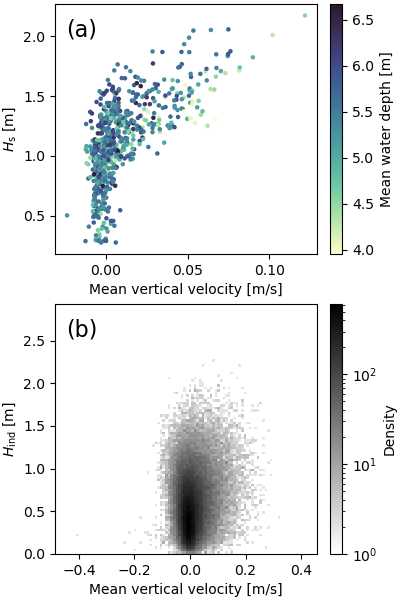

In [119]:
from scipy.stats import binned_statistic
import matplotlib as mpl
nanind = np.isnan(wm)
# Compute individual wave heights and wave-mean vertical velocities
h0w = dsv.eta_hyd.resample(time='20T').map(nan50_mean).reindex(time=dsv.time, method='nearest')
zc, Hw, Hc, Ht, wm, h0w = get_waveheights(dsv.eta_lin.values, mean_signal=dsv.uU.values, 
                                          mean_signal2=h0w.values)

fig, axes = plt.subplots(figsize=(4,6), nrows=2, constrained_layout=True)
vmin = 4
vmax = 7
h0 = dsv.eta_hyd.resample(time='20T').map(nan50_mean) 
cs = axes[0].scatter(w_mean.values, hs, c=h0, s=5, cmap=cmocean.cm.deep)
cbar=fig.colorbar(cs)
cbar.set_label('Mean water depth [m]')
axes[0].set_xlabel('Mean vertical velocity [m/s]')
axes[0].set_ylabel(r'$H_\mathrm{s}$ [m]')
# ax.scatter(wm, Hw, c=h0w, s=5, cmap=cmocean.cm.deep)
_, _, _, im1 = axes[1].hist2d(wm[~nanind], Hw[~nanind], norm=mpl.colors.LogNorm(),
                    cmap=mpl.cm.gray_r, bins=[100, 100])
cbar = fig.colorbar(im1)
cbar.set_label('Density')
axes[1].set_xlabel('Mean vertical velocity [m/s]')
axes[1].set_ylabel(r'$H_\mathrm{ind}$ [m]')
# cax = axes[1].inset_axes([0.0, 1.04, 1, 0.05], transform=axes[1].transAxes)
# cbar = fig.colorbar(im1, ax=axes[1], cax=cax, orientation='horizontal')
# cax.xaxis.set_ticks_position('top')
ann = ['(a)', '(b)']
for ax, a in zip(axes.flatten(), ann):
#     if a in ['(a)', '(b)', '(c)']:
    ax.annotate(a, xy=(0.04, 0.87), xycoords='axes fraction', fontsize=16)
#     else:
#         ax.annotate(a, xy=(0.85, 0.87), xycoords='axes fraction', fontsize=20)
    # ax.grid(True, alpha=0.6)

outdir = '/home/mikapm/Documents'
fn = os.path.join(outdir, 'h_vs_w.png')
plt.savefig(fn, bbox_inches='tight', dpi=300)
plt.show()

In [92]:
np.sum(np.isnan(Hw))

0

In [97]:
dsv.eta_hyd.resample(time='20T').map(nan50_mean).reindex(time=dsv.time, method='nearest')

<xarray.DataArray 'eta_hyd' (time: 789504)>
array([5.62139751, 5.62139751, 5.62139751, ..., 5.67416327, 5.67416327,
       5.67416327])
Coordinates:
  * time     (time) datetime64[ns] 2022-06-26T10:00:03.031250 ... 2022-07-24T...